In [1]:
import os
import platform
from IPython.display import clear_output
from numpy import typeDict
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Windows-10-10.0.22621-SP0


<ipython-input-1-386e6332e93b>:4: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from numpy import typeDict


In [2]:
!pip install tensorflow

In [3]:
!nvidia-smi

Sun Feb 18 16:18:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0              14W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
MyDrive = '/kaggle/working'
PROJECT_DIR = './Downloads/violencedataset'

In [5]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [6]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

  0%|          | 0/350 [00:00<?, ?it/s]

we have 
1000 Violence videos 
1000 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 350/350 [02:52<00:00,  2.03it/s]

Wall time: 4min 19s


In [7]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

13979

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [9]:
!pip install imutils
clear_output()

In [10]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [11]:
epochs = 70

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(weights='imagenet',
                            pooling='avg',
                            alpha=1.0,
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model2 = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model2.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model2

model2 = load_layers()

model2.summary()

Compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Co

 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 32, 32, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 33, 33, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 16, 16, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_d

 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 8, 8, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 8, 8, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 8, 8, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
          

 block_9_project_BN (BatchN  (None, 8, 8, 64)             256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 8, 8, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 8, 8, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 8, 8, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
          

 block_13_expand_BN (BatchN  (None, 8, 8, 576)            2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 8, 8, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 9, 9, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 4, 4, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D

                                                                                                  
 block_16_depthwise (Depthw  (None, 4, 4, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 4, 4, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 4, 4, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_

In [15]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

#if TPU_INIT:
#    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
#    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model2.stop_training = True

In [16]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights2.h5'

model2_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model2_checkpoints, tensorboard_callback, early_stopping, lr_plat]

In [17]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history_final1234 = model2.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model2.load_weights(checkpoint_filepath)

Training head...
Epoch 1/70
2446/2447 [============================>.] - ETA: 0s - loss: 0.8159 - accuracy: 0.5448
Epoch 1: val_loss improved from inf to 0.68974, saving model to ModelWeights2.h5
2447/2447 [==============================] - 115s 46ms/step - loss: 0.8159 - accuracy: 0.5448 - val_loss: 0.6897 - val_accuracy: 0.6221 - lr: 1.0000e-05
Epoch 2/70
2446/2447 [============================>.] - ETA: 0s - loss: 0.5631 - accuracy: 0.7128
Epoch 2: val_loss improved from 0.68974 to 0.46889, saving model to ModelWeights2.h5
2447/2447 [==============================] - 87s 36ms/step - loss: 0.5630 - accuracy: 0.7128 - val_loss: 0.4689 - val_accuracy: 0.7716 - lr: 1.8000e-05
Epoch 3/70
2445/2447 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8259
Epoch 3: val_loss improved from 0.46889 to 0.35001, saving model to ModelWeights2.h5
2447/2447 [==============================] - 93s 38ms/step - loss: 0.4012 - accuracy: 0.8260 - val_loss: 0.3500 - val_accuracy: 0.853

2447/2447 [==============================] - 83s 34ms/step - loss: 0.1491 - accuracy: 0.9488 - val_loss: 0.1687 - val_accuracy: 0.9359 - lr: 1.0576e-05
Epoch 26/70
2447/2447 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9485
Epoch 26: val_loss improved from 0.16866 to 0.16782, saving model to ModelWeights2.h5
2447/2447 [==============================] - 84s 34ms/step - loss: 0.1479 - accuracy: 0.9485 - val_loss: 0.1678 - val_accuracy: 0.9363 - lr: 1.0461e-05
Epoch 27/70
2447/2447 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9497
Epoch 27: val_loss improved from 0.16782 to 0.16701, saving model to ModelWeights2.h5
2447/2447 [==============================] - 83s 34ms/step - loss: 0.1469 - accuracy: 0.9497 - val_loss: 0.1670 - val_accuracy: 0.9363 - lr: 1.0369e-05
Epoch 28/70
2447/2447 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9508
Epoch 28: val_loss improved from 0.16701 to 0.16621, saving model to ModelW

Epoch 50/70
2445/2447 [============================>.] - ETA: 0s - loss: 0.1279 - accuracy: 0.9575
Epoch 50: val_loss improved from 0.15394 to 0.15338, saving model to ModelWeights2.h5
2447/2447 [==============================] - 84s 34ms/step - loss: 0.1279 - accuracy: 0.9575 - val_loss: 0.1534 - val_accuracy: 0.9425 - lr: 1.0002e-05
Epoch 51/70
2445/2447 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.9582
Epoch 51: val_loss improved from 0.15338 to 0.15287, saving model to ModelWeights2.h5
2447/2447 [==============================] - 85s 35ms/step - loss: 0.1273 - accuracy: 0.9582 - val_loss: 0.1529 - val_accuracy: 0.9425 - lr: 1.0002e-05
Epoch 52/70
2445/2447 [============================>.] - ETA: 0s - loss: 0.1265 - accuracy: 0.9586
Epoch 52: val_loss improved from 0.15287 to 0.15246, saving model to ModelWeights2.h5
2447/2447 [==============================] - 85s 35ms/step - loss: 0.1265 - accuracy: 0.9586 - val_loss: 0.1525 - val_accuracy: 0.9430 - lr: 

In [ ]:
#history2 = model.fit(
#    X_train_nn ,y_train,
#    validation_data = (X_test_nn, y_test),
#   epochs=80,
#   initial_epoch=40,
#   callbacks=callbacks
#

In [ ]:
#checkpoint_filepath = 'ModelWeights.h5'

In [ ]:
#from tensorflow.keras.models import load_model

In [ ]:
#model.load_weights('./ModelWeights.h5')

In [18]:
%matplotlib inline

def print_graph(item, index, history_final1234):
    plt.figure()
    train_values = history_final1234.history[item][0:index]
    plt.plot(train_values)
    test_values = history_final1234.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history_final1234):
    for key, item in enumerate(history_final1234.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history_final1234):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history_final1234:
        index = get_best_epoch(test_loss, history_final1234)
        print('Best Epochs: ', index)

        train_accuracy = history_final1234.history['accuracy'][index]
        train_loss = history_final1234.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history_final1234)
        print_graph('accuracy', index, history_final1234)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  46
Accuracy on train: 0.9576903581619263 	Loss on train: 0.12986965477466583
Accuracy on test: 0.9458750486373901 	Loss on test: 0.1457243263721466


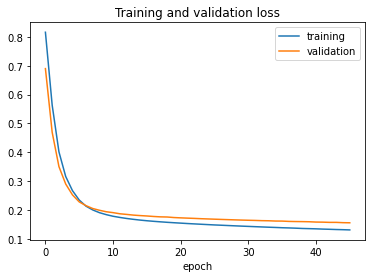

<Figure size 432x288 with 0 Axes>

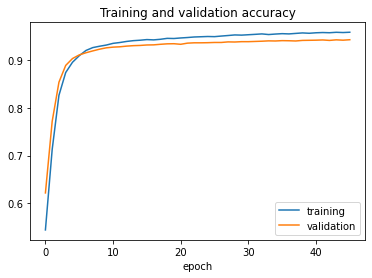

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [20]:
model_summary(model2, history_final1234)

In [21]:
print("Evaluating network...")
predictions = model2.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
132/132 [==============================] - 29s 211ms/step


> Correct Predictions: 3967
> Wrong Predictions: 227


<ipython-input-22-de97b9dafb2a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
<ipython-input-22-de97b9dafb2a>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

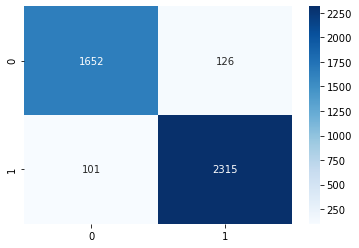

              precision    recall  f1-score   support

 NonViolence       0.94      0.93      0.94      1778
    Violence       0.95      0.96      0.95      2416

    accuracy                           0.95      4194
   macro avg       0.95      0.94      0.94      4194
weighted avg       0.95      0.95      0.95      4194



In [22]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

In [23]:
args_model = "modelnew34.h5"
model2.save(args_model)

C:\Users\SAHIL\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
